In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import jarque_bera, mstats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
# -------------------------------
# 2. Model Specification
# -------------------------------
print("Model Specification")
print("- Dependent variable: GWL_average (Groundwater Level)")
print("- Covariates: Rainfall, Climate, Soil composition, Lagged GWL, Time index")
print("- Spatial unit: District")
print("- Temporal unit: Month")
print("Equation: GWL_{i,t} = β0 + β1*RF + β2*t2m + β3*tp + ... + βk*Xk_{i,t} + ε_{i,t}")


Model Specification
- Dependent variable: GWL_average (Groundwater Level)
- Covariates: Rainfall, Climate, Soil composition, Lagged GWL, Time index
- Spatial unit: District
- Temporal unit: Month
Equation: GWL_{i,t} = β0 + β1*RF + β2*t2m + β3*tp + ... + βk*Xk_{i,t} + ε_{i,t}


In [4]:
# 3. Load Data
# -------------------------------
df = pd.read_csv("final_dataset.csv")

# Drop fid + fill NaN
if "fid" in df.columns:
    df = df.drop(columns=["fid"])
df = df.fillna(0)

# Ensure year/month are integers
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

# Create proper date column
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-01"
)

# Sort by district and date
df = df.sort_values(["DISTRICT","date"]).reset_index(drop=True)

# Time index & lag
df["time_index"] = (df["date"].dt.year - df["date"].dt.year.min())*12 + df["date"].dt.month
df["GWL_lag1"] = df.groupby("DISTRICT")["GWL_average"].shift(1).fillna(0)


In [5]:
# -------------------------------
# 4. Pre-processing
# -------------------------------
predictors = [
    "RF_average","t2m_value","tp_value","swvl1_value","swvl2_value",
    "sand_pct","floamy_pct","f_clayey_pct","GWL_lag1","time_index"
]
dependent = "GWL_average"

# Winsorize outliers in climate vars
for c in ["RF_average","t2m_value","tp_value","swvl1_value","swvl2_value"]:
    if c in df.columns:
        df[c] = mstats.winsorize(df[c], limits=[0.01,0.01])

X = df[predictors]
y = df[dependent]
X = sm.add_constant(X)


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
GWL_average,954.0,-4.279040,6.831152,-28.180109,-8.485060,0.000000,0.000000,23.480000
RF_average,954.0,1.077508,2.123195,0.000000,0.000000,0.032258,1.035337,10.648387
t2m_value,954.0,5.045189,10.080654,0.000000,0.000000,0.000000,0.000000,32.727072
tp_value,954.0,0.448460,1.428995,0.000000,0.000000,0.000000,0.000000,7.590961
swvl1_value,954.0,0.050343,0.103562,0.000000,0.000000,0.000000,0.000000,0.384935
swvl2_value,954.0,0.050808,0.103537,0.000000,0.000000,0.000000,0.000000,0.378109
sand_pct,954.0,0.002505,0.003882,0.000000,0.000000,0.000000,0.006270,0.009498
floamy_pct,954.0,0.031916,0.009372,0.014838,0.025162,0.035215,0.040295,0.046521
f_clayey_pct,954.0,0.000160,0.000455,0.000000,0.000000,0.000000,0.000000,0.001506
GWL_lag1,954.0,-4.218278,6.800491,-28.180109,-8.424167,0.000000,0.000000,23.480000


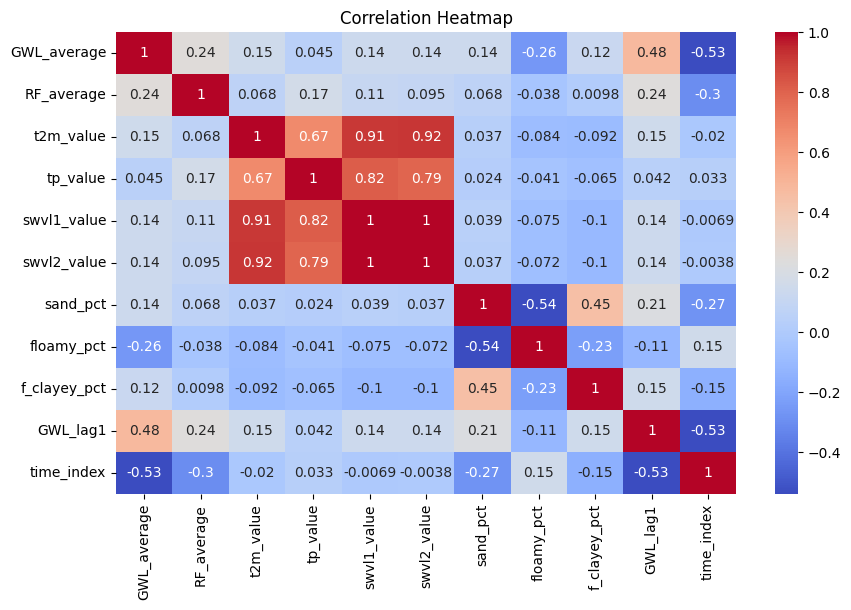

In [6]:
# -------------------------------
# 5. EDA
# -------------------------------
print("\nSummary Statistics:")
display(df[[dependent] + predictors].describe().T)

plt.figure(figsize=(10,6))
sns.heatmap(df[[dependent] + predictors].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

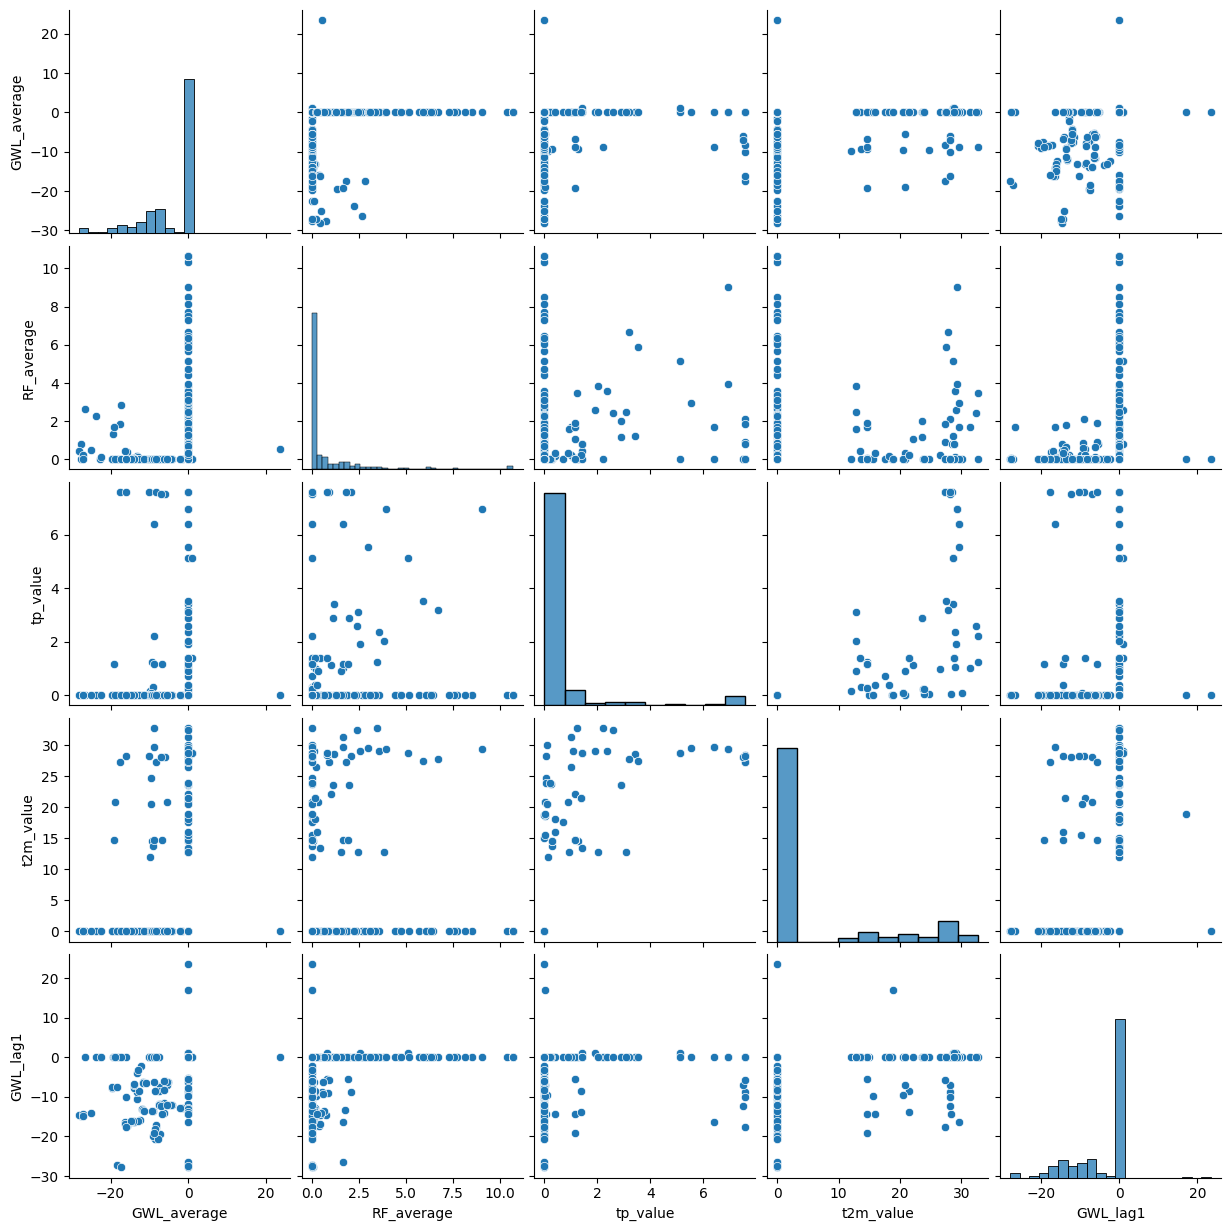

In [7]:

sns.pairplot(df[[dependent,"RF_average","tp_value","t2m_value","GWL_lag1"]].sample(300))
plt.show()


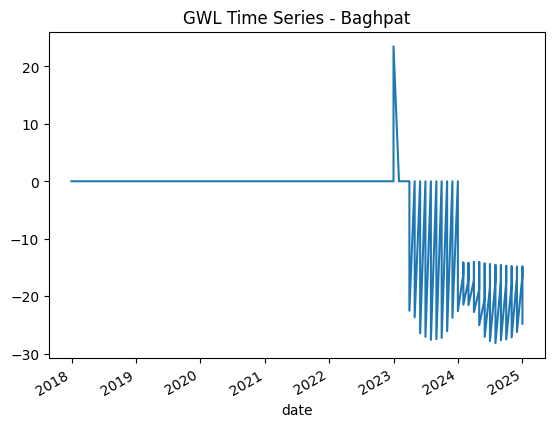

In [8]:

sample = df["DISTRICT"].unique()[0]
df[df["DISTRICT"]==sample].set_index("date")[dependent].plot(title=f"GWL Time Series - {sample}")
plt.show()

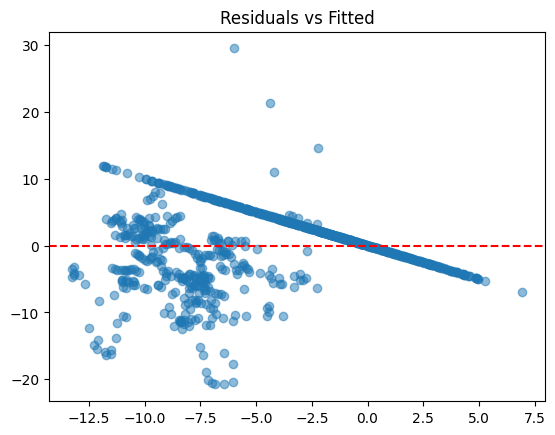


VIF Table:
          feature         VIF
0          const   32.565125
1     RF_average    1.166004
2      t2m_value    6.849063
3       tp_value    4.460385
4    swvl1_value  212.880859
5    swvl2_value  178.599101
6       sand_pct    1.757631
7     floamy_pct    1.420562
8   f_clayey_pct    1.292992
9       GWL_lag1    1.484782
10    time_index    1.543994
Breusch–Pagan: (np.float64(124.7152885942903), np.float64(5.572711466029219e-22), np.float64(14.181681577737333), np.float64(1.3331665551472642e-23))
Durbin–Watson: 2.2559357714330592
Jarque–Bera: SignificanceResult(statistic=np.float64(276.6501457836691), pvalue=np.float64(8.436923946008192e-61))


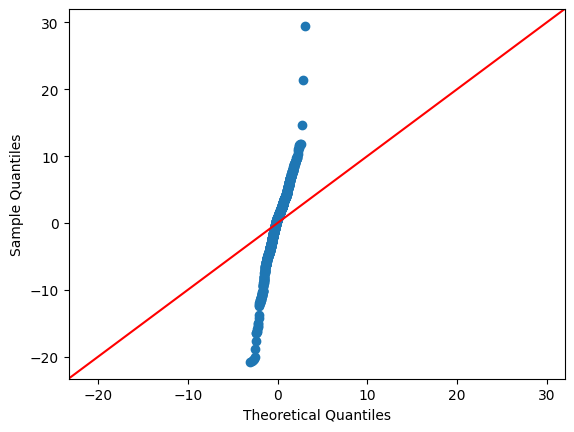

In [9]:
# -------------------------------
# 6. Model Assumptions
# -------------------------------
ols_model = sm.OLS(y, X).fit()

# Residuals
resid = ols_model.resid
fitted = ols_model.fittedvalues

# Linearity: residual vs fitted
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted")
plt.show()

# Multicollinearity: VIF
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF Table:\n", vif)

# Exogeneity: Discuss in report (cannot be tested directly)

# Homoscedasticity
print("Breusch–Pagan:", het_breuschpagan(resid, ols_model.model.exog))

# Autocorrelation
print("Durbin–Watson:", durbin_watson(resid))

# Normality
print("Jarque–Bera:", jarque_bera(resid))
sm.qqplot(resid, line="45")
plt.show()


In [10]:
# -------------------------------
# 7. Model Selection (AIC/BIC)
# -------------------------------
candidates = {
    "full_model": predictors,
    "climate_only": ["RF_average","t2m_value","tp_value","swvl1_value","swvl2_value"],
    "soil_only": ["sand_pct","floamy_pct","f_clayey_pct"]
}

results = []
for name, vars_list in candidates.items():
    Xi = sm.add_constant(df[vars_list])
    m = sm.OLS(y, Xi).fit()
    results.append({
        "Model": name,
        "AIC": m.aic,
        "BIC": m.bic,
        "Adj R²": m.rsquared_adj
    })

print("\nModel Comparison (AIC/BIC):")
print(pd.DataFrame(results))


Model Comparison (AIC/BIC):
          Model          AIC          BIC    Adj R²
0    full_model  5900.887275  5954.354575  0.397646
1  climate_only  6287.836477  6317.000459  0.091636
2     soil_only  6309.776979  6329.219634  0.068562


In [11]:
# -------------------------------
# 8. Model Estimation & Diagnostics
# -------------------------------
print("\nOLS Full Model Summary:")
print(ols_model.summary())

coef_table = pd.DataFrame({
    "coef": ols_model.params,
    "std_err": ols_model.bse,
    "t": ols_model.tvalues,
    "p_value": ols_model.pvalues
})
print("\nCoefficient Table:\n", coef_table)



OLS Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:            GWL_average   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     63.91
Date:                Sat, 11 Oct 2025   Prob (F-statistic):           6.22e-99
Time:                        03:27:37   Log-Likelihood:                -2939.4
No. Observations:                 954   AIC:                             5901.
Df Residuals:                     943   BIC:                             5954.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.3443


Regression Prediction:
RMSE: 5.110213121911152
MAE: 3.77638777246731
R²: 0.36297034732487066


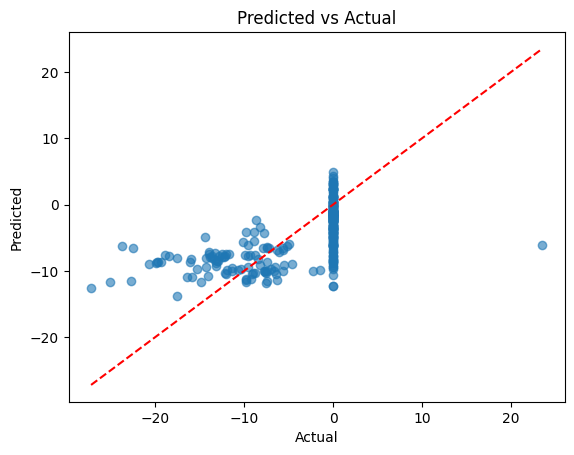

In [12]:
# -------------------------------
# 9. Prediction (Train/Test + Classification)
# -------------------------------
# Regression prediction
X_train, X_test, y_train, y_test_mlr = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = sm.OLS(y_train, X_train).fit()
y_pred_mlr = reg_model.predict(X_test)

print("\nRegression Prediction:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_mlr, y_pred_mlr)))
print("MAE:", mean_absolute_error(y_test_mlr, y_pred_mlr))
print("R²:", r2_score(y_test_mlr, y_pred_mlr))

plt.scatter(y_test_mlr, y_pred_mlr, alpha=0.6)
plt.plot([y_test_mlr.min(), y_test_mlr.max()], [y_test_mlr.min(), y_test_mlr.max()], "r--")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()


In [13]:

# Classification: Decline vs Not
df["GWL_change"] = df["GWL_average"] - df["GWL_lag1"]
df["decline"] = (df["GWL_change"] < 0).astype(int)

X_clf = df[predictors]
y_clf = df["decline"]

Xtr, Xte, ytr, yte = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)

clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, ytr)
y_pred_clf = clf.predict(Xte)

cm = confusion_matrix(yte, y_pred_clf)
print("\nConfusion Matrix:\n", cm)
print(f"Accuracy={accuracy_score(yte,y_pred_clf):.3f}, Precision={precision_score(yte,y_pred_clf):.3f}, Recall={recall_score(yte,y_pred_clf):.3f}, F1={f1_score(yte,y_pred_clf):.3f}")


Confusion Matrix:
 [[218  13]
 [ 32  24]]
Accuracy=0.843, Precision=0.649, Recall=0.429, F1=0.516


**ASSIGNMENT-2: COMPARSION WITH ANN**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

In [28]:
# -------------------------------
# 1. Data Preparation & Scaling
# -------------------------------
# (Assume df, X, y are already defined from earlier MLR section)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print(" Data scaled and split successfully.")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}\n")



 Data scaled and split successfully.
Train: (566, 11), Validation: (101, 11), Test: (287, 11)



In [29]:
# -------------------------------
# 2 ANN Model Definition
# -------------------------------
input_dim = X_train.shape[1]
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# -------------------------------
# 3  Training Configuration
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
ann_runtime = time.time() - start_time

print(f"\ ANN training completed in {ann_runtime:.2f} seconds.\n")



Epoch 1/200
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 29.4809 - mae: 3.2111

<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2253518136.py:18: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ ANN training completed in {ann_runtime:.2f} seconds.\n")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23.3356 - mae: 2.8835 - val_loss: 15.8792 - val_mae: 2.4232 - learning_rate: 6.2500e-05
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 19.4249 - mae: 2.7002 - val_loss: 15.8857 - val_mae: 2.4259 - learning_rate: 6.2500e-05
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 20.4741 - mae: 2.6458 - val_loss: 15.9066 - val_mae: 2.4278 - learning_rate: 6.2500e-05
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 21.2633 - mae: 2.7569 - val_loss: 15.9201 - val_mae: 2.4283 - learning_rate: 6.2500e-05
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19.4840 - mae: 2.7028 - val_loss: 15.9154 - val_mae: 2.4256 - learning_rate: 6.2500e-05
Epoch 6/200
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 14.3497 - mae: 2.3621
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.1476 - mae: 2.7780 - val_loss: 15.9066 - val_mae: 2.4228 - learning_rate: 6.2

In [32]:
# --- 4. Evaluation on Test Data ---
y_pred_ann = model.predict(X_test)

ann_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ann))
ann_mae = mean_absolute_error(y_test, y_pred_ann)
ann_r2 = r2_score(y_test, y_pred_ann)

print(f"📊 ANN Performance (Western UP Region):")
print(f"RMSE: {ann_rmse:.4f}")
print(f"MAE:  {ann_mae:.4f}")
print(f"R²:   {ann_r2:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
📊 ANN Performance (Western UP Region):
RMSE: 4.2502
MAE:  2.3619
R²:   0.5593


In [33]:
# -------------------------------
# 5.  Compare ANN vs Existing MLR
# -------------------------------
# Use your previously obtained MLR metrics here:
mlr_rmse = 5.1102
mlr_mae = 3.7764
mlr_r2 = 0.3630

comparison_df = pd.DataFrame({
    'Model': ['MLR', 'ANN (MLP)'],
    'RMSE': [mlr_rmse, ann_rmse],
    'MAE': [mlr_mae, ann_mae],
    'R²': [mlr_r2, ann_r2],
    'Training Time (s)': ['-', f'{ann_runtime:.2f}']
})

print("\n Model Comparison Table:")
display(comparison_df)



 Model Comparison Table:


,Model,RMSE,MAE,R²,Training Time (s)
0,MLR,5.110200,3.776400,0.363000,-
1,ANN (MLP),4.250186,2.361888,0.559346,2.34


In [35]:
# -------------------------------
# Paired t-test for statistical significance
# -------------------------------
# Since both models used the same dataset and test samples:
y_pred_mlr = mlr_model.predict(sm.add_constant(X_test, has_constant='add'))
AE_mlr = np.abs(y_test - y_pred_mlr)
AE_ann = np.abs(y_test - y_pred_ann.flatten())

t_stat, p_value = ttest_rel(AE_mlr, AE_ann)

print(f"\n Paired t-test Results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The ANN performance improvement over MLR is statistically significant.")
else:
    print(" No statistically significant difference between ANN and MLR performance.")


 Paired t-test Results:
t-statistic: 12.5947
p-value: 0.0000
The ANN performance improvement over MLR is statistically significant.


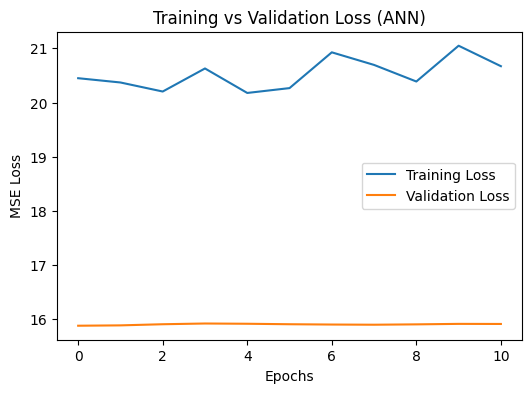

In [36]:
# -------------------------------
# 6 Training Loss Curve
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (ANN)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


 Computing Permutation Feature Importance...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 

/tmp/ipython-input-1740480144.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='crest')


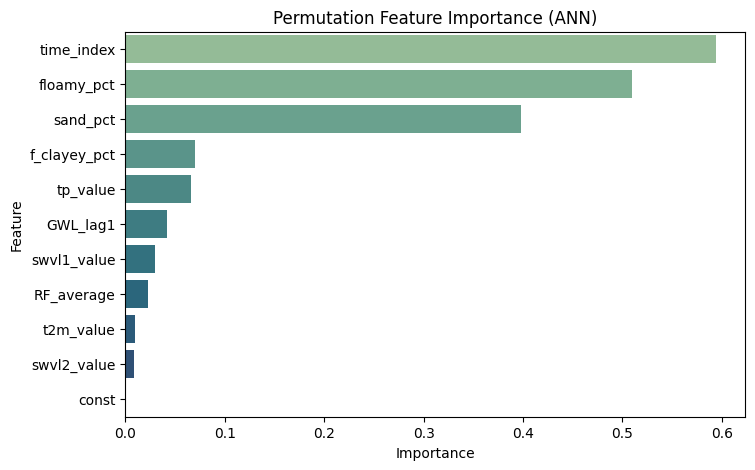


 Generating SHAP summary...


PermutationExplainer explainer: 201it [00:52,  3.57it/s]
/tmp/ipython-input-1740480144.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:200], feature_names=X.columns)


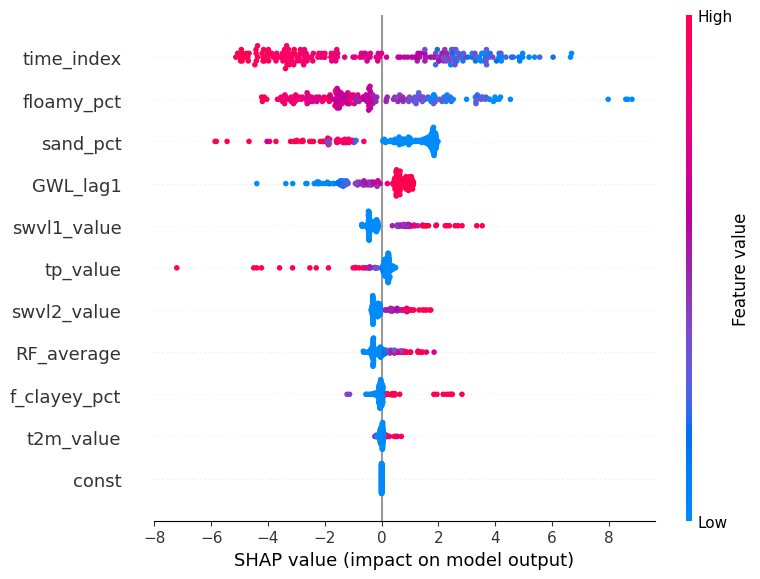

In [37]:
# -------------------------------
# 7️ Explainability (Permutation Importance + SHAP)
# -------------------------------
print("\n Computing Permutation Feature Importance...")
perm_results = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, scoring='r2'
)

importance_df = pd.DataFrame({
    'Feature': list(X.columns),
    'Importance': perm_results.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='crest')
plt.title("Permutation Feature Importance (ANN)")
plt.show()

print("\n Generating SHAP summary...")
explainer = shap.Explainer(model, X_train[:200])
shap_values = explainer(X_test[:200])
shap.summary_plot(shap_values, X_test[:200], feature_names=X.columns)

In [38]:
# -------------------------------
# 8️ Hyperparameter Summary
# -------------------------------
hyperparams = {
    "Optimizer": "Adam",
    "Learning Rate": 1e-3,
    "Loss": "MSE",
    "Metrics": "MAE",
    "Batch Size": 64,
    "Epochs (max)": 200,
    "Patience": 10,
    "Dropout": "0.2 after each Dense layer",
    "Runtime (s)": f"{ann_runtime:.2f}"
}

print("\n Hyperparameter Summary:")
for k, v in hyperparams.items():
    print(f"{k:20s}: {v}")


 Hyperparameter Summary:
Optimizer           : Adam
Learning Rate       : 0.001
Loss                : MSE
Metrics             : MAE
Batch Size          : 64
Epochs (max)        : 200
Patience            : 10
Dropout             : 0.2 after each Dense layer
Runtime (s)         : 2.34
